# **Lung-Nodule-Detection: Part-1 Data Preprocessing**

## 目标

在Part-1部分，探索CT数据并进行预处理。具体目标如下：

- 显示CT切片图像，建立对数据的**直观感受**
- 应用各类**数据增强**方法弥补原始数据集数据量不够充分的缺陷（医学影像数据较难获取）
- 显示经过数据增强后的CT切片图像，简单**验证**数据增强效果是否正常

## 内容

本节主要由两部分组成

- 显示原始数据集的CT切片（标注结节位置）
- 显示经过数据增强处理后的结节切片（与增强前对比）

## 设置
**必须**先执行一次设置代码块

请先**满足**以下条件：
- 下载 [LUNA2016 Dataset](https://luna16.grand-challenge.org/Download/)
- 解压下载后的数据集到 ***data-unversioned/luna*** 目录下（可不必下载全部subset）

In [1]:
import os
import sys
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# 获取当前工作目录
current_path = os.getcwd()

# 获取当前目录的最后一个字符串（即最后一个文件夹名）
last_directory = os.path.basename(current_path)

# 检查是否是 notebook
if last_directory == 'notebooks':
    # 切换到上一级目录
    os.chdir('..')

#print(f"切换到目录: {os.getcwd()}")

sys.path.append('src')  # 将模块所在的路径添加到 sys.path

from util.vis import *
from core.model_seg import SegmentationAugmentation
from collections import namedtuple

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## 显示原始数据集中的结节切片

代码路径：
- 绘图相关函数位于 ***src/util/vis.py***
- 数据集定义位于 ***src/core/dsets_cls.py***

### 查看结节的属性

用于训练结节分类模型的数据封装成***LunaDataset***，内部维护一个名为***candidateInfo_list***的列表。  
***candidateInfo_list***里的元素类型为***namedtuple***，定义如下
```
CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    'isNodule_bool, hasAnnotation_bool, isMal_bool, diameter_mm, series_uid, center_xyz',
)
```

||isNodule_bool|hasAnnotation_bool|isMal_bool|diameter_mm|series_uid|center_xyz|
|-|-|-|-|-|-|-|
|**含义**|是否结节|是否由专业医生注释过|是否恶性|直径|所属CT的唯一序列号|结节中心|

In [2]:
pos_samples = findPositiveSamples()

2025-05-07 16:08:03,350 INFO     pid:689426 core.dsets_cls:284:__init__ <core.dsets_cls.LunaDataset object at 0x7f9fa8d939d0>: 550896 training samples, 549714 neg, 1182 pos, unbalanced ratio


0 CandidateInfoTuple(isNodule_bool=True, hasAnnotation_bool=True, isMal_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(67.82725575, 85.37992457, -109.74672379999998))
1 CandidateInfoTuple(isNodule_bool=True, hasAnnotation_bool=True, isMal_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(47.67105722, 37.64251989, -99.89039388))
2 CandidateInfoTuple(isNodule_bool=True, hasAnnotation_bool=True, isMal_bool=True, diameter_mm=27.44242293, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311', center_xyz=(-46.94966448, 72.63645381, -95.64452131))
3 CandidateInfoTuple(isNodule_bool=True, hasAnnotation_bool=True, isMal_bool=True, diameter_mm=27.07544345, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156', center_xyz=(-103.13251120000001, -5.774672551, -206.3554703))
4 CandidateInfoTuple(is

### 绘制结节影像

*showCandidate* 的函数签名如下：
```
def showCandidate(series_uid, batch_ndx=None, **kwargs):
```
*showCandidate* 接收一个 *series_uid* 用于选择CT影像，可从上一个 *cell* 的输出中任意选取

CT影像分为 **病人坐标系（xyz）** 和 **数组坐标系（CRI）**

对应关系如下：
- x -> C
- y -> R
- z -> I

总共绘制5行x3列，每个图像含义如下：

||col-1|col-2|col-3|
|-|-|-|-|
|**row-1**|完整CT影像结节中心对应的 ***I*** 切片|完整CT影像结节中心对应的 ***R*** 切片|完整CT影像结节中心对应的 ***C*** 切片|
|**row-2**|裁剪后的结节中心对应的 ***I*** 切片|裁剪后的结节中心对应的 ***R*** 切片|裁剪后的结节中心对应的 ***C*** 切片|
|**row-3**|裁剪后的结节非中心对应的 ***I*** 切片|裁剪后的结节非中心对应的 ***I*** 切片|裁剪后的结节非中心对应的 ***I*** 切片|
|**row-4**|裁剪后的结节非中心对应的 ***I*** 切片|裁剪后的结节非中心对应的 ***I*** 切片|裁剪后的结节非中心对应的 ***I*** 切片|
|**row-5**|裁剪后的结节非中心对应的 ***I*** 切片|裁剪后的结节非中心对应的 ***I*** 切片|裁剪后的结节非中心对应的 ***I*** 切片|

**注意！** 由于CT扫描仪每次仅生成 ***2D*** 影像，同时病人 **沿着z坐标轴** 不停运动，最终合成 ***3D*** 的影像。所以 **z方向的分辨率要比xy方向小** ，最终绘制的 ***R*** 切片和 ***C*** 切片显得有些压缩。（这里只显示原始数据，对模型训练没有影响，绘制函数里 **未作校正** ）

2025-05-07 16:08:03,455 INFO     pid:689426 core.dsets_cls:284:__init__ <core.dsets_cls.LunaDataset object at 0x7f9fa8d933d0>: 984 training samples, 979 neg, 5 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886 0 False [0, 1, 2, 3, 4]


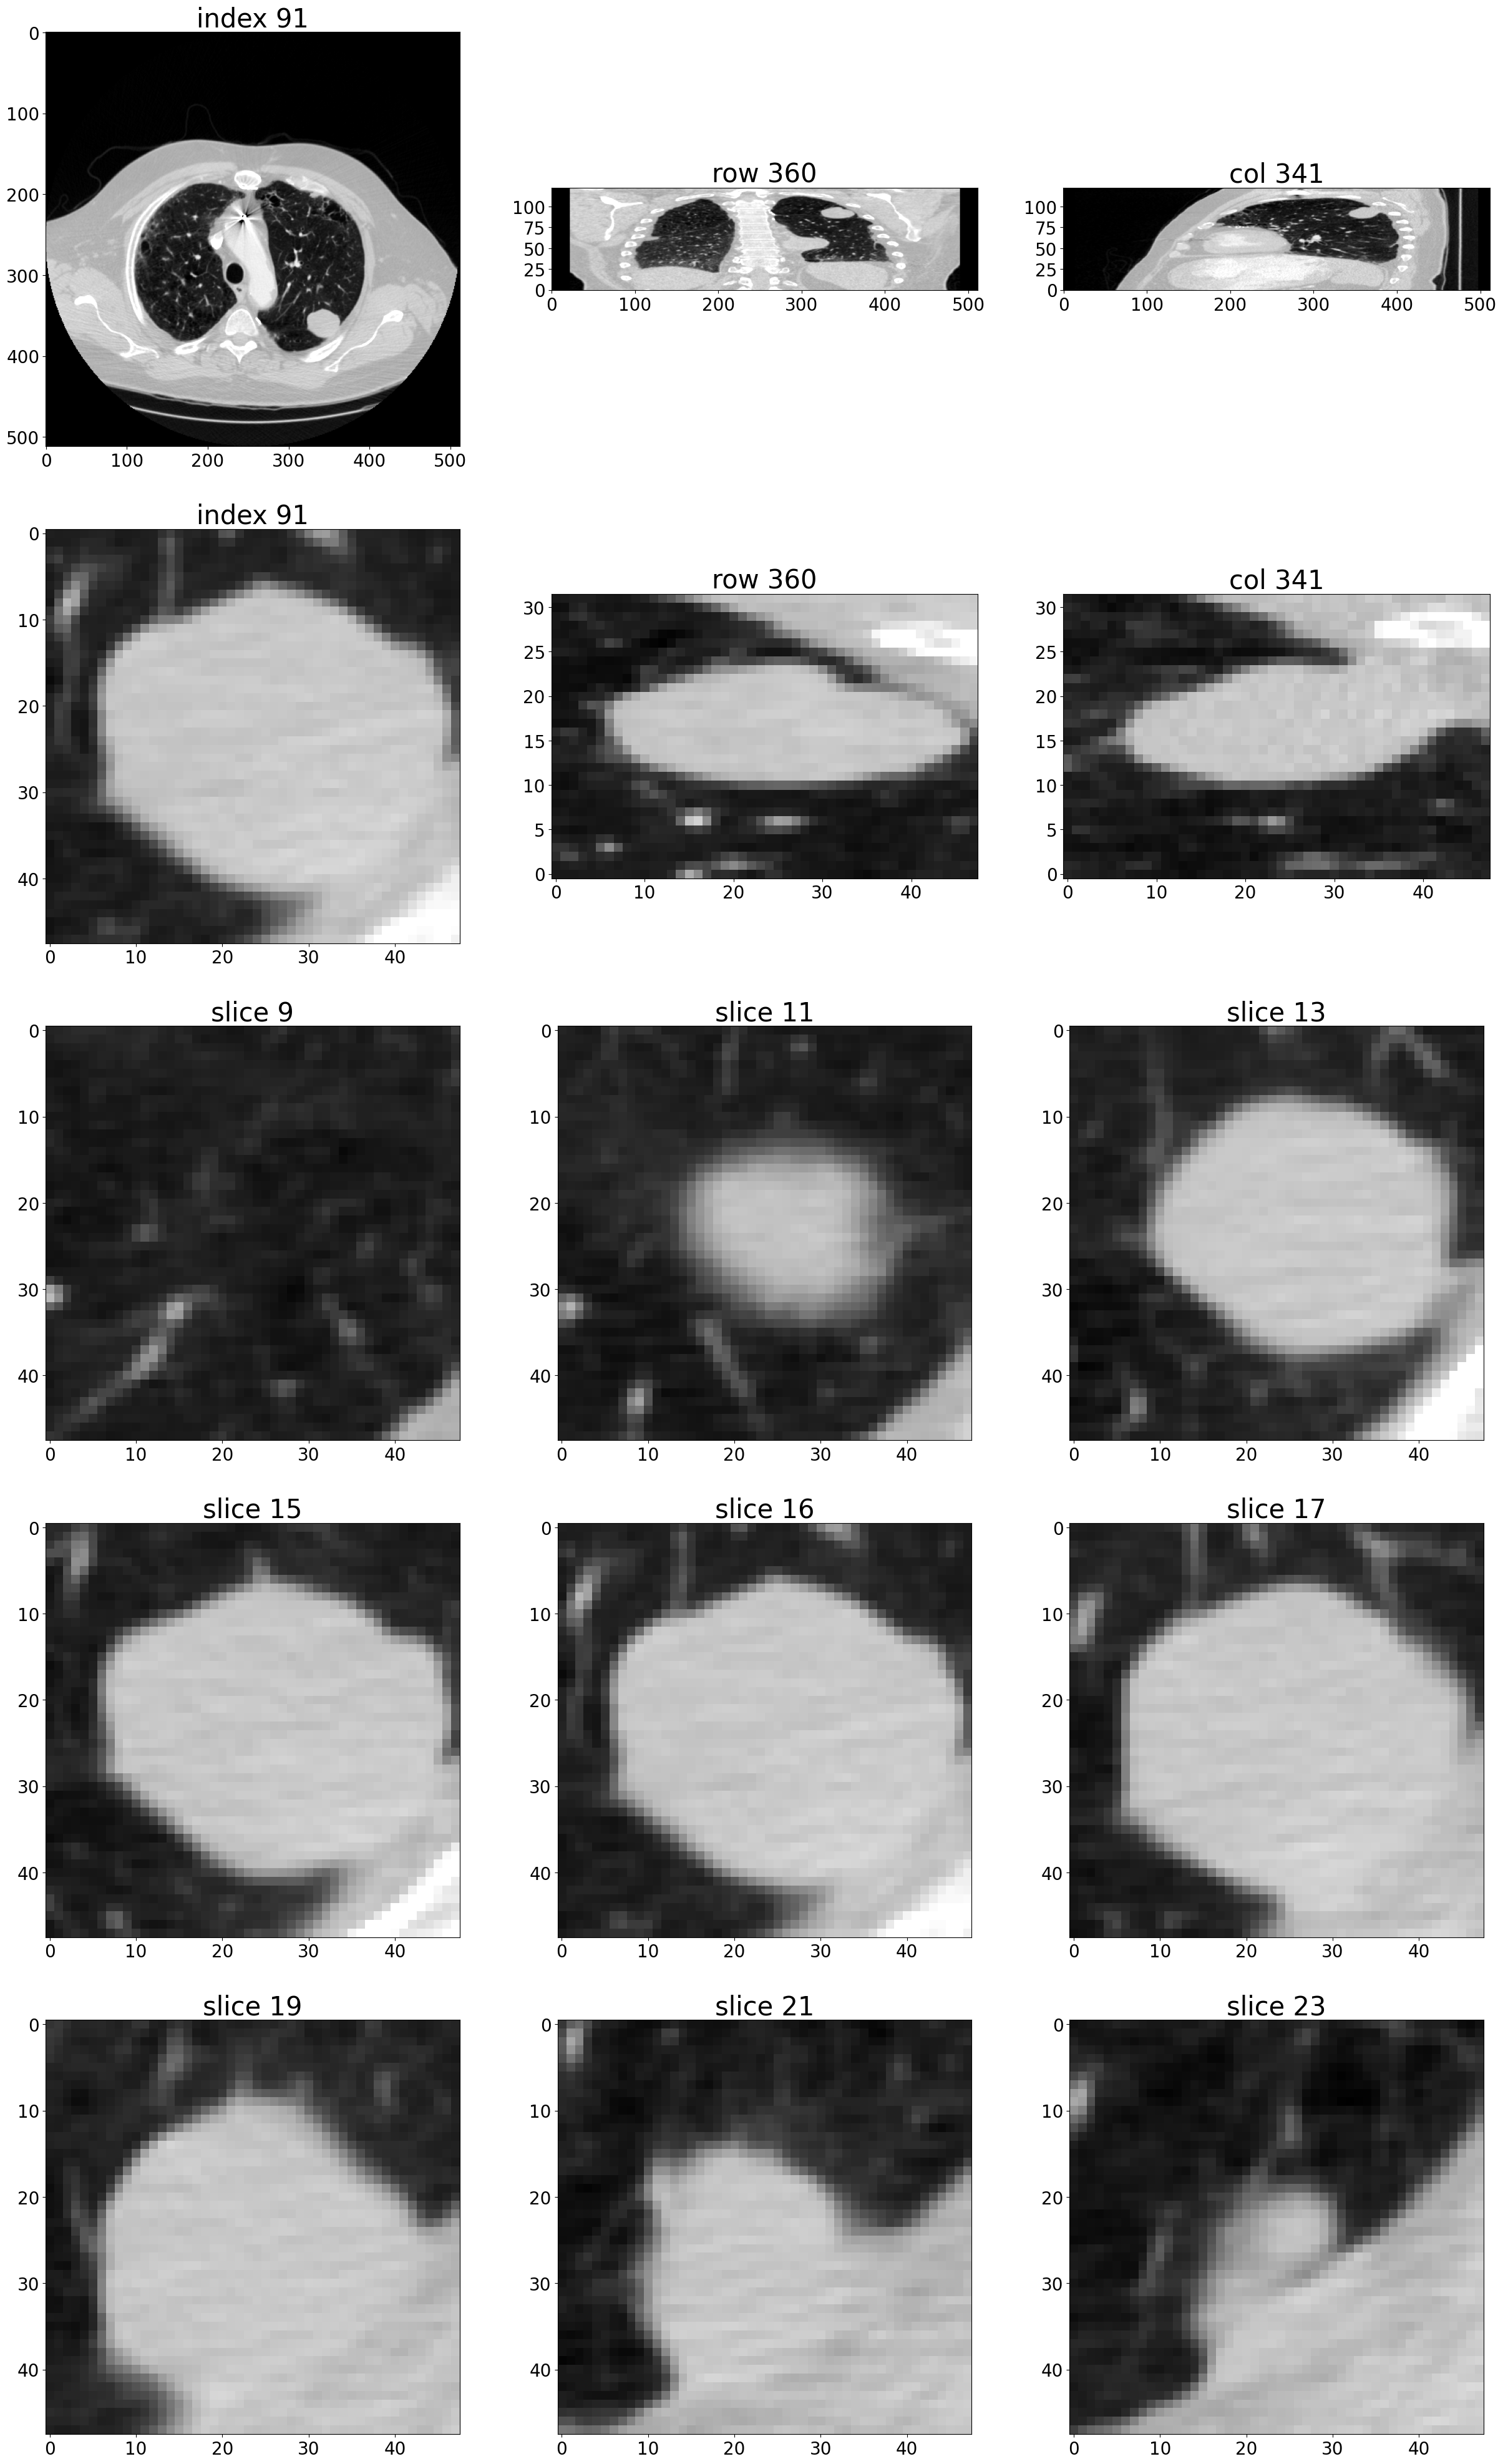

In [3]:
showCandidate(pos_samples[0].series_uid)

## 显示经过数据增强处理后的结节切片

代码路径：
- 数据增强方法定义位于 ***src/core/model_seg.py***
- 数据集定义位于 ***src/core/dsets_cls.py***

### 数据增强方法

数据增强方法封装在 ***SegmentationAugmentation*** 类

类定义如下：
```
class SegmentationAugmentation(nn.Module):
    def __init__(
            self, flip=None, offset=None, scale=None, rotate=None, noise=None
    ):

# ..............................................................................
# ..............................................................................

    def forward(self, input_g, label_g):
        transform_t = self._build2dTransformMatrix()
        transform_t = transform_t.expand(input_g.shape[0], -1, -1)
        transform_t = transform_t.to(input_g.device, torch.float32)
        affine_t = F.affine_grid(transform_t[:,:2],
                input_g.size(), align_corners=False)

# ..............................................................................
# ..............................................................................
```

采用的数据增强方法如下:
- flip
- offset
- scale
- rotate
- noise


### 对不同类别的增强效果进行查验

分别实例化不同的数据增强类：
- 不作增强处理
- 只作 **Flip** 处理
- 只作 **Offset** 处理
- 只作 **Scale** 处理
- 只作 **Rotate** 处理
- 只作 **Noise** 处理
- 结合所有增强方法（3个）

In [4]:
AugmentationTuple = namedtuple(
    'AugmentationTuple',
    'title_str, flip, offset, scale, rotate, noise',
)

augmentation_list = [
    AugmentationTuple("None", False, None, None, False, None),
    AugmentationTuple("Flip", True, None, None, False, None),
    AugmentationTuple("Offset", False, 0.1, None, False, None),
    AugmentationTuple("Scale", False, None, 0.2, False, None),
    AugmentationTuple("Rotate", False, None, None, True, None),
    AugmentationTuple("Noise", False, None, None, False, 25.0),
    AugmentationTuple("All", True, 0.1, 0.2, True, 25.0),
    AugmentationTuple("All", True, 0.1, 0.2, True, 25.0),
    AugmentationTuple("All", True, 0.1, 0.2, True, 25.0)
]

augmentation_model_list = [
    SegmentationAugmentation(flip=flip, offset=offset, scale=scale, rotate=rotate, noise=noise)
    for _, flip, offset, scale, rotate, noise in augmentation_list
]


### 绘制增强后的结节切片

总共绘制3行x3列，每个图像含义如下：

||col-1|col-2|col-3|
|-|-|-|-|
|**row-1**|None|Only Flip|Only Offset|
|**row-2**|Only Scale|Only Rotate|Only Noise|
|**row-3**|All|All|All|

**注意！** 增强效果处理时带有 **随机性** ，每次运行结果并不完全相同。若要完全复现，可参考如下代码。
```
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
```

2025-05-07 16:08:07,515 INFO     pid:689426 core.dsets_cls:284:__init__ <core.dsets_cls.LunaDataset object at 0x7f9eac1f4070>: 550896 training samples, 549714 neg, 1182 pos, unbalanced ratio


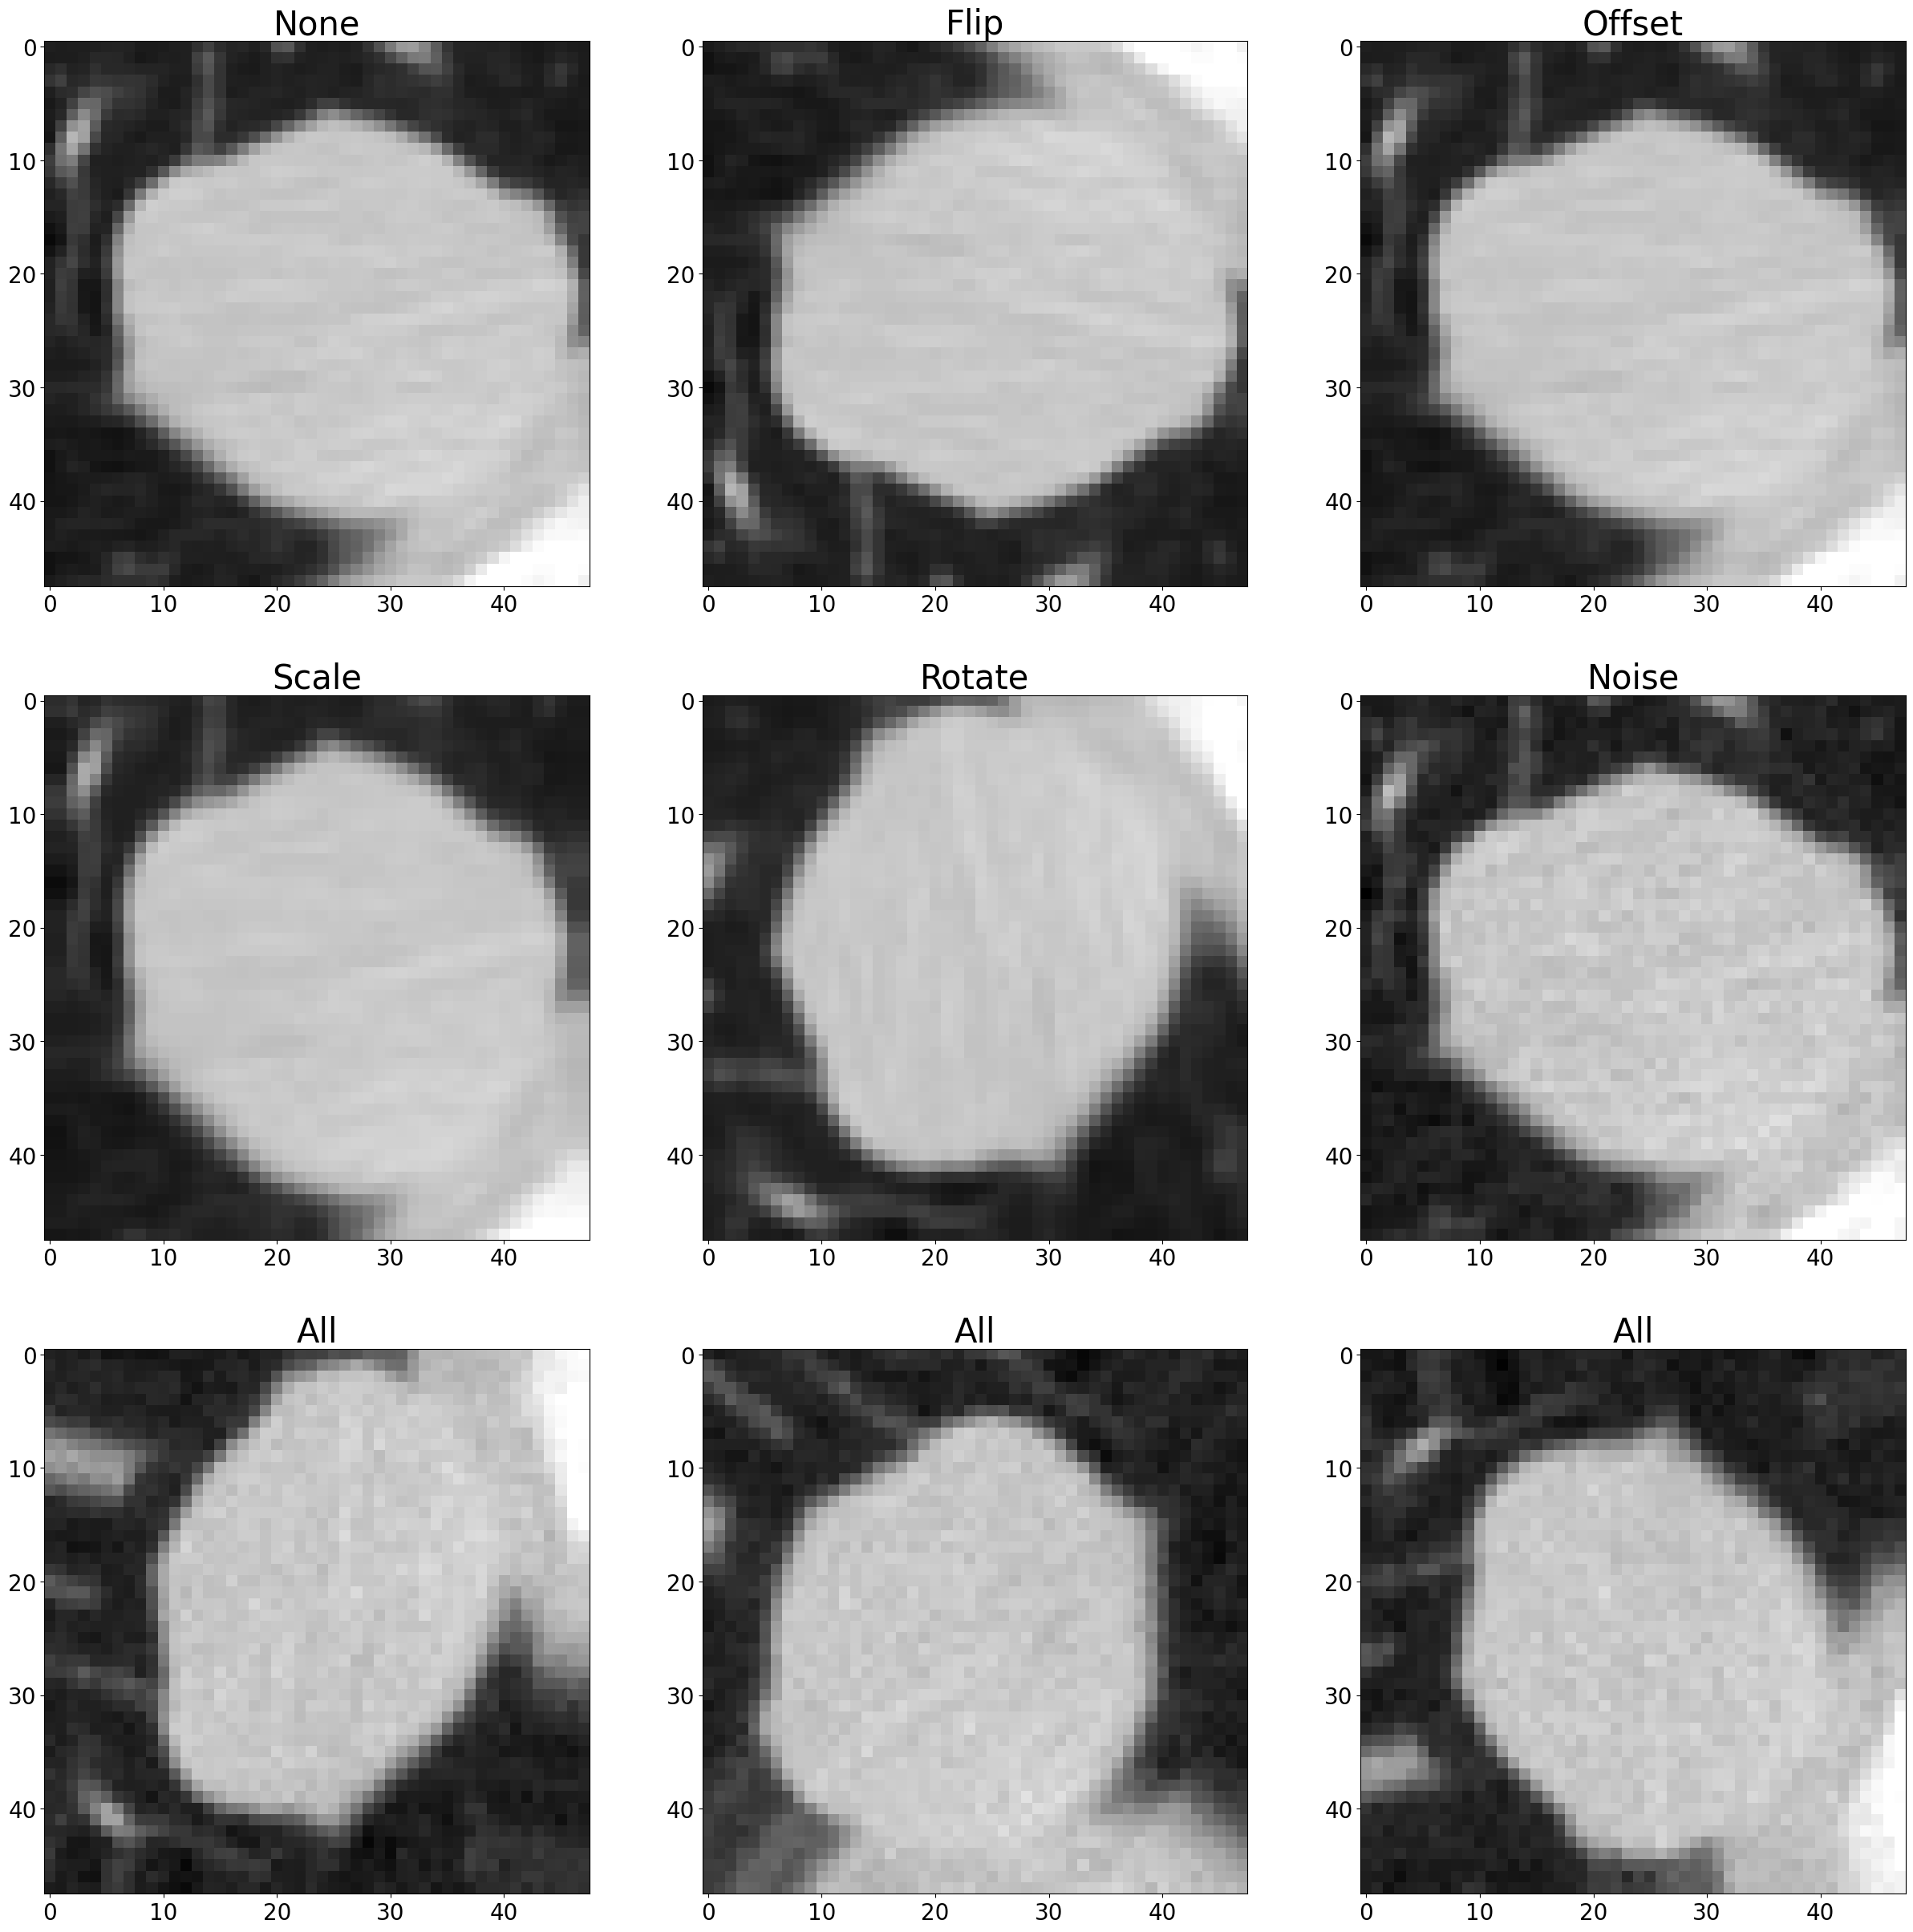

In [5]:
fig = plt.figure(figsize=(30,30))

ds = LunaDataset(sortby_str="label_and_size")
sample_tup = ds[0]

clim=(-1000.0, 300)

for i, ((title_str, *rm1), augmentation_model) in enumerate(zip(augmentation_list, augmentation_model_list)):
    input_t, *rm2 = sample_tup
    input_g = input_t.to(device)

    output_g, _ = augmentation_model(input_g)
    output_t = output_g.to("cpu")

    subplot = fig.add_subplot(3, 3, i+1)
    subplot.set_title(title_str, fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(output_t[0][16], clim=clim, cmap='gray')
